In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.regularizers import l2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
lstm_units = 50
w_decay = 0.05
dropout_rate = 0.2
epochs_to_run = 500
sequence_length = 200

In [3]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [4]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

141148


In [5]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [6]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [7]:
def nlp_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    output = Dense(units=1, activation='sigmoid')(lstm1[1])

    model = Model(inputs, output)
    return model


model = nlp_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm1.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14114800  
_________________________________________________________________
lstm (LSTM)                  [(None, 200, 50), (None,  30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 14,145,051
Trainable params: 30,251
Non-trainable params: 14,114,800
_________________________________________________________________
Epoch 1/500
130/133 [============================>.] - ETA: 0s - loss: 8.7831 - accuracy: 0.5505
Epoch 00001: val_accuracy improved from -inf to 0.57129, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==========================

133/133 [==============================] - 2s 15ms/step - loss: 0.5427 - accuracy: 0.8020 - val_loss: 0.5467 - val_accuracy: 0.8036
Epoch 24/500
131/133 [============================>.] - ETA: 0s - loss: 0.5426 - accuracy: 0.7965
Epoch 00024: val_accuracy did not improve from 0.80359
133/133 [==============================] - 2s 13ms/step - loss: 0.5430 - accuracy: 0.7961 - val_loss: 0.5439 - val_accuracy: 0.7941
Epoch 25/500
131/133 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.8044
Epoch 00025: val_accuracy improved from 0.80359 to 0.80548, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.5382 - accuracy: 0.8048 - val_loss: 0.5307 - val_accuracy: 0.8055
Epoch 26/500
132/133 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.8035
Epoch 00026: val_accuracy did not improve from 0.80548
133/133 [==============================] - 2s 13ms/step - loss: 0.5347 - accuracy: 0.8032 - va

131/133 [============================>.] - ETA: 0s - loss: 0.4794 - accuracy: 0.8292
Epoch 00051: val_accuracy did not improve from 0.82153
133/133 [==============================] - 2s 13ms/step - loss: 0.4789 - accuracy: 0.8292 - val_loss: 0.4801 - val_accuracy: 0.8187
Epoch 52/500
130/133 [============================>.] - ETA: 0s - loss: 0.4744 - accuracy: 0.8341
Epoch 00052: val_accuracy did not improve from 0.82153
133/133 [==============================] - 2s 13ms/step - loss: 0.4745 - accuracy: 0.8336 - val_loss: 0.4867 - val_accuracy: 0.8121
Epoch 53/500
130/133 [============================>.] - ETA: 0s - loss: 0.4811 - accuracy: 0.8317
Epoch 00053: val_accuracy did not improve from 0.82153
133/133 [==============================] - 2s 13ms/step - loss: 0.4798 - accuracy: 0.8327 - val_loss: 0.4801 - val_accuracy: 0.8178
Epoch 54/500
129/133 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.8266
Epoch 00054: val_accuracy did not improve from 0.82153
133/1

Epoch 79/500
131/133 [============================>.] - ETA: 0s - loss: 0.4420 - accuracy: 0.8573
Epoch 00079: val_accuracy did not improve from 0.84042
133/133 [==============================] - 2s 13ms/step - loss: 0.4420 - accuracy: 0.8568 - val_loss: 0.4538 - val_accuracy: 0.8319
Epoch 80/500
131/133 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8511
Epoch 00080: val_accuracy did not improve from 0.84042
133/133 [==============================] - 2s 13ms/step - loss: 0.4338 - accuracy: 0.8500 - val_loss: 0.4541 - val_accuracy: 0.8338
Epoch 81/500
131/133 [============================>.] - ETA: 0s - loss: 0.4395 - accuracy: 0.8581
Epoch 00081: val_accuracy did not improve from 0.84042
133/133 [==============================] - 2s 13ms/step - loss: 0.4405 - accuracy: 0.8570 - val_loss: 0.4635 - val_accuracy: 0.8300
Epoch 82/500
131/133 [============================>.] - ETA: 0s - loss: 0.4328 - accuracy: 0.8547
Epoch 00082: val_accuracy improved from 0.84042

129/133 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8694
Epoch 00107: val_accuracy did not improve from 0.85080
133/133 [==============================] - 2s 14ms/step - loss: 0.4098 - accuracy: 0.8686 - val_loss: 0.4342 - val_accuracy: 0.8404
Epoch 108/500
131/133 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8721
Epoch 00108: val_accuracy improved from 0.85080 to 0.85175, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.4076 - accuracy: 0.8726 - val_loss: 0.4484 - val_accuracy: 0.8517
Epoch 109/500
133/133 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8700
Epoch 00109: val_accuracy did not improve from 0.85175
133/133 [==============================] - 2s 14ms/step - loss: 0.4058 - accuracy: 0.8700 - val_loss: 0.4311 - val_accuracy: 0.8480
Epoch 110/500
131/133 [============================>.] - ETA: 0s - loss: 0.4103 - accuracy: 0.8669
Epoch 

Epoch 135/500
131/133 [============================>.] - ETA: 0s - loss: 0.3857 - accuracy: 0.8838
Epoch 00135: val_accuracy did not improve from 0.86308
133/133 [==============================] - 2s 13ms/step - loss: 0.3854 - accuracy: 0.8842 - val_loss: 0.4223 - val_accuracy: 0.8527
Epoch 136/500
130/133 [============================>.] - ETA: 0s - loss: 0.3850 - accuracy: 0.8882
Epoch 00136: val_accuracy did not improve from 0.86308
133/133 [==============================] - 2s 13ms/step - loss: 0.3842 - accuracy: 0.8887 - val_loss: 0.4254 - val_accuracy: 0.8470
Epoch 137/500
129/133 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8719
Epoch 00137: val_accuracy did not improve from 0.86308
133/133 [==============================] - 2s 13ms/step - loss: 0.3909 - accuracy: 0.8710 - val_loss: 0.4237 - val_accuracy: 0.8565
Epoch 138/500
131/133 [============================>.] - ETA: 0s - loss: 0.3838 - accuracy: 0.8786
Epoch 00138: val_accuracy did not improve f

Epoch 164/500
133/133 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8880
Epoch 00164: val_accuracy did not improve from 0.86402
133/133 [==============================] - 2s 14ms/step - loss: 0.3680 - accuracy: 0.8880 - val_loss: 0.4178 - val_accuracy: 0.8593
Epoch 165/500
129/133 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.8869
Epoch 00165: val_accuracy did not improve from 0.86402
133/133 [==============================] - 2s 14ms/step - loss: 0.3659 - accuracy: 0.8878 - val_loss: 0.4228 - val_accuracy: 0.8612
Epoch 166/500
131/133 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8912
Epoch 00166: val_accuracy improved from 0.86402 to 0.86497, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.3724 - accuracy: 0.8915 - val_loss: 0.4121 - val_accuracy: 0.8650
Epoch 167/500
131/133 [============================>.] - ETA: 0s - loss: 0.3751 - accuracy:

Epoch 192/500
131/133 [============================>.] - ETA: 0s - loss: 0.3607 - accuracy: 0.8948
Epoch 00192: val_accuracy did not improve from 0.87252
133/133 [==============================] - 2s 13ms/step - loss: 0.3609 - accuracy: 0.8946 - val_loss: 0.4056 - val_accuracy: 0.8706
Epoch 193/500
133/133 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8948
Epoch 00193: val_accuracy improved from 0.87252 to 0.87535, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.3573 - accuracy: 0.8948 - val_loss: 0.4019 - val_accuracy: 0.8754
Epoch 194/500
131/133 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.8950
Epoch 00194: val_accuracy did not improve from 0.87535
133/133 [==============================] - 2s 13ms/step - loss: 0.3540 - accuracy: 0.8948 - val_loss: 0.4209 - val_accuracy: 0.8555
Epoch 195/500
132/133 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy:

131/133 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8991
Epoch 00220: val_accuracy did not improve from 0.87913
133/133 [==============================] - 2s 13ms/step - loss: 0.3493 - accuracy: 0.8984 - val_loss: 0.3998 - val_accuracy: 0.8735
Epoch 221/500
131/133 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8929
Epoch 00221: val_accuracy did not improve from 0.87913
133/133 [==============================] - 2s 13ms/step - loss: 0.3562 - accuracy: 0.8937 - val_loss: 0.4034 - val_accuracy: 0.8706
Epoch 222/500
131/133 [============================>.] - ETA: 0s - loss: 0.3376 - accuracy: 0.9048
Epoch 00222: val_accuracy did not improve from 0.87913
133/133 [==============================] - 2s 13ms/step - loss: 0.3370 - accuracy: 0.9052 - val_loss: 0.4116 - val_accuracy: 0.8631
Epoch 223/500
131/133 [============================>.] - ETA: 0s - loss: 0.3434 - accuracy: 0.9029
Epoch 00223: val_accuracy did not improve from 0.87913
13

131/133 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.9027
Epoch 00248: val_accuracy did not improve from 0.88102
133/133 [==============================] - 2s 13ms/step - loss: 0.3375 - accuracy: 0.9031 - val_loss: 0.3949 - val_accuracy: 0.8754
Epoch 249/500
131/133 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.9020
Epoch 00249: val_accuracy did not improve from 0.88102
133/133 [==============================] - 2s 13ms/step - loss: 0.3375 - accuracy: 0.9026 - val_loss: 0.4026 - val_accuracy: 0.8763
Epoch 250/500
131/133 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.9036
Epoch 00250: val_accuracy did not improve from 0.88102
133/133 [==============================] - 2s 13ms/step - loss: 0.3329 - accuracy: 0.9038 - val_loss: 0.3992 - val_accuracy: 0.8791
Epoch 251/500
131/133 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.9012
Epoch 00251: val_accuracy did not improve from 0.88102
13

Epoch 277/500
131/133 [============================>.] - ETA: 0s - loss: 0.3358 - accuracy: 0.9031
Epoch 00277: val_accuracy did not improve from 0.88480
133/133 [==============================] - 2s 13ms/step - loss: 0.3357 - accuracy: 0.9031 - val_loss: 0.4178 - val_accuracy: 0.8725
Epoch 278/500
132/133 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.9093
Epoch 00278: val_accuracy did not improve from 0.88480
133/133 [==============================] - 2s 13ms/step - loss: 0.3298 - accuracy: 0.9095 - val_loss: 0.4049 - val_accuracy: 0.8735
Epoch 279/500
131/133 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.9070
Epoch 00279: val_accuracy did not improve from 0.88480
133/133 [==============================] - 2s 13ms/step - loss: 0.3289 - accuracy: 0.9069 - val_loss: 0.3973 - val_accuracy: 0.8820
Epoch 280/500
130/133 [============================>.] - ETA: 0s - loss: 0.3251 - accuracy: 0.9115
Epoch 00280: val_accuracy did not improve f

Epoch 306/500
131/133 [============================>.] - ETA: 0s - loss: 0.3298 - accuracy: 0.9053
Epoch 00306: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3293 - accuracy: 0.9055 - val_loss: 0.4108 - val_accuracy: 0.8716
Epoch 307/500
131/133 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.9148
Epoch 00307: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3201 - accuracy: 0.9149 - val_loss: 0.4227 - val_accuracy: 0.8725
Epoch 308/500
131/133 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.9177
Epoch 00308: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3147 - accuracy: 0.9175 - val_loss: 0.4029 - val_accuracy: 0.8820
Epoch 309/500
131/133 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.9153
Epoch 00309: val_accuracy did not improve f

Epoch 335/500
131/133 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.9101
Epoch 00335: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3156 - accuracy: 0.9104 - val_loss: 0.4024 - val_accuracy: 0.8763
Epoch 336/500
131/133 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.9148
Epoch 00336: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3093 - accuracy: 0.9149 - val_loss: 0.4243 - val_accuracy: 0.8697
Epoch 337/500
131/133 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.9108
Epoch 00337: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3174 - accuracy: 0.9112 - val_loss: 0.3980 - val_accuracy: 0.8810
Epoch 338/500
131/133 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.9103
Epoch 00338: val_accuracy did not improve f

Epoch 364/500
131/133 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.9120
Epoch 00364: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3129 - accuracy: 0.9126 - val_loss: 0.4245 - val_accuracy: 0.8697
Epoch 365/500
131/133 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.9113
Epoch 00365: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3217 - accuracy: 0.9107 - val_loss: 0.4301 - val_accuracy: 0.8744
Epoch 366/500
131/133 [============================>.] - ETA: 0s - loss: 0.3096 - accuracy: 0.9153
Epoch 00366: val_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 13ms/step - loss: 0.3097 - accuracy: 0.9156 - val_loss: 0.4030 - val_accuracy: 0.8791
Epoch 367/500
131/133 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.9144
Epoch 00367: val_accuracy did not improve f

Epoch 393/500
131/133 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.9220
Epoch 00393: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2920 - accuracy: 0.9225 - val_loss: 0.4193 - val_accuracy: 0.8791
Epoch 394/500
131/133 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.9198
Epoch 00394: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2997 - accuracy: 0.9204 - val_loss: 0.3886 - val_accuracy: 0.8933
Epoch 395/500
131/133 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.9232
Epoch 00395: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2982 - accuracy: 0.9218 - val_loss: 0.3903 - val_accuracy: 0.8895
Epoch 396/500
131/133 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.9234
Epoch 00396: val_accuracy did not improve f

Epoch 422/500
131/133 [============================>.] - ETA: 0s - loss: 0.3081 - accuracy: 0.9141
Epoch 00422: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.3080 - accuracy: 0.9138 - val_loss: 0.4057 - val_accuracy: 0.8876
Epoch 423/500
131/133 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.9253
Epoch 00423: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2924 - accuracy: 0.9253 - val_loss: 0.3884 - val_accuracy: 0.8857
Epoch 424/500
131/133 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.9196
Epoch 00424: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2989 - accuracy: 0.9201 - val_loss: 0.3879 - val_accuracy: 0.8876
Epoch 425/500
131/133 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.9189
Epoch 00425: val_accuracy did not improve f

Epoch 451/500
131/133 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.9241
Epoch 00451: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2945 - accuracy: 0.9241 - val_loss: 0.3869 - val_accuracy: 0.8876
Epoch 452/500
131/133 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.9239
Epoch 00452: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2926 - accuracy: 0.9239 - val_loss: 0.3931 - val_accuracy: 0.8867
Epoch 453/500
131/133 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.9170
Epoch 00453: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.3002 - accuracy: 0.9168 - val_loss: 0.4002 - val_accuracy: 0.8829
Epoch 454/500
131/133 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.9215
Epoch 00454: val_accuracy did not improve f

Epoch 480/500
131/133 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.9210
Epoch 00480: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2951 - accuracy: 0.9211 - val_loss: 0.4053 - val_accuracy: 0.8839
Epoch 481/500
131/133 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.9227
Epoch 00481: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2959 - accuracy: 0.9223 - val_loss: 0.3778 - val_accuracy: 0.8848
Epoch 482/500
131/133 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.9299
Epoch 00482: val_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 13ms/step - loss: 0.2833 - accuracy: 0.9301 - val_loss: 0.4009 - val_accuracy: 0.8848
Epoch 483/500
131/133 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.9253
Epoch 00483: val_accuracy did not improve f

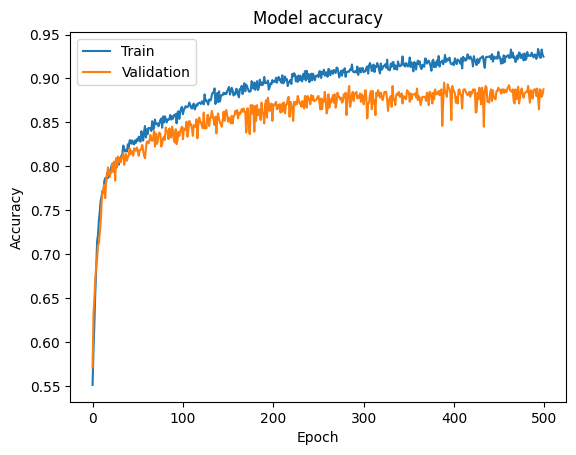

In [8]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model = load_model('./weight_cp/weight_lstm1.hdf5')
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       661
           1       0.90      0.87      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.8888888888888888


In [10]:
def nlp_lstm2(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, [output, output_td, avg])
    return model


model = nlp_lstm2(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2.hdf5', save_freq="epoch",  verbose=1, monitor='val_avg_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])








(None, 80)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14114800    input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 50), (N 30200       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 200, 1)       51          lstm_1[0][0]                     
____________________________________________________________________________

133/133 [==============================] - ETA: 0s - loss: 4.2549 - op_main_loss: 0.5561 - op_conv_loss: 0.6928 - avg_loss: 0.6140 - op_main_accuracy: 0.7415 - op_conv_accuracy: 0.5095 - avg_accuracy: 0.7450
Epoch 00006: val_avg_accuracy improved from 0.70727 to 0.72238, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 18ms/step - loss: 4.2549 - op_main_loss: 0.5561 - op_conv_loss: 0.6928 - avg_loss: 0.6140 - op_main_accuracy: 0.7415 - op_conv_accuracy: 0.5095 - avg_accuracy: 0.7450 - val_loss: 3.9565 - val_op_main_loss: 0.5519 - val_op_conv_loss: 0.6932 - val_avg_loss: 0.6090 - val_op_main_accuracy: 0.7224 - val_op_conv_accuracy: 0.4958 - val_avg_accuracy: 0.7224
Epoch 7/500
133/133 [==============================] - ETA: 0s - loss: 3.6897 - op_main_loss: 0.5319 - op_conv_loss: 0.6931 - avg_loss: 0.5990 - op_main_accuracy: 0.7521 - op_conv_accuracy: 0.4858 - avg_accuracy: 0.7521
Epoch 00007: val_avg_accuracy improved from 0.72238 to 0.73182, 

133/133 [==============================] - 2s 18ms/step - loss: 1.6679 - op_main_loss: 0.4042 - op_conv_loss: 0.4463 - avg_loss: 0.4180 - op_main_accuracy: 0.8225 - op_conv_accuracy: 0.7963 - avg_accuracy: 0.8166 - val_loss: 1.6454 - val_op_main_loss: 0.4025 - val_op_conv_loss: 0.4386 - val_avg_loss: 0.4149 - val_op_main_accuracy: 0.8178 - val_op_conv_accuracy: 0.8017 - val_avg_accuracy: 0.8140
Epoch 18/500
133/133 [==============================] - ETA: 0s - loss: 1.6103 - op_main_loss: 0.3958 - op_conv_loss: 0.4272 - avg_loss: 0.4054 - op_main_accuracy: 0.8336 - op_conv_accuracy: 0.8110 - avg_accuracy: 0.8268
Epoch 00018: val_avg_accuracy improved from 0.81398 to 0.82247, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 18ms/step - loss: 1.6103 - op_main_loss: 0.3958 - op_conv_loss: 0.4272 - avg_loss: 0.4054 - op_main_accuracy: 0.8336 - op_conv_accuracy: 0.8110 - avg_accuracy: 0.8268 - val_loss: 1.6093 - val_op_main_loss: 0.3970 - val_op_con

133/133 [==============================] - ETA: 0s - loss: 1.3354 - op_main_loss: 0.3485 - op_conv_loss: 0.3310 - avg_loss: 0.3339 - op_main_accuracy: 0.8552 - op_conv_accuracy: 0.8533 - avg_accuracy: 0.8603
Epoch 00029: val_avg_accuracy improved from 0.84042 to 0.85080, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 18ms/step - loss: 1.3354 - op_main_loss: 0.3485 - op_conv_loss: 0.3310 - avg_loss: 0.3339 - op_main_accuracy: 0.8552 - op_conv_accuracy: 0.8533 - avg_accuracy: 0.8603 - val_loss: 1.3799 - val_op_main_loss: 0.3568 - val_op_conv_loss: 0.3523 - val_avg_loss: 0.3491 - val_op_main_accuracy: 0.8414 - val_op_conv_accuracy: 0.8404 - val_avg_accuracy: 0.8508
Epoch 30/500
133/133 [==============================] - ETA: 0s - loss: 1.3065 - op_main_loss: 0.3407 - op_conv_loss: 0.3201 - avg_loss: 0.3248 - op_main_accuracy: 0.8629 - op_conv_accuracy: 0.8648 - avg_accuracy: 0.8665
Epoch 00030: val_avg_accuracy did not improve from 0.85080
133/

Epoch 41/500
133/133 [==============================] - ETA: 0s - loss: 1.1781 - op_main_loss: 0.3134 - op_conv_loss: 0.2673 - avg_loss: 0.2832 - op_main_accuracy: 0.8691 - op_conv_accuracy: 0.8868 - avg_accuracy: 0.8835
Epoch 00041: val_avg_accuracy did not improve from 0.85175
133/133 [==============================] - 2s 16ms/step - loss: 1.1781 - op_main_loss: 0.3134 - op_conv_loss: 0.2673 - avg_loss: 0.2832 - op_main_accuracy: 0.8691 - op_conv_accuracy: 0.8868 - avg_accuracy: 0.8835 - val_loss: 1.3438 - val_op_main_loss: 0.3520 - val_op_conv_loss: 0.3400 - val_avg_loss: 0.3381 - val_op_main_accuracy: 0.8442 - val_op_conv_accuracy: 0.8442 - val_avg_accuracy: 0.8489
Epoch 42/500
133/133 [==============================] - ETA: 0s - loss: 1.1538 - op_main_loss: 0.3037 - op_conv_loss: 0.2613 - avg_loss: 0.2747 - op_main_accuracy: 0.8823 - op_conv_accuracy: 0.8911 - avg_accuracy: 0.8927
Epoch 00042: val_avg_accuracy improved from 0.85175 to 0.85458, saving model to ./weight_cp\weight_ls

Epoch 53/500
133/133 [==============================] - ETA: 0s - loss: 1.0931 - op_main_loss: 0.2918 - op_conv_loss: 0.2347 - avg_loss: 0.2547 - op_main_accuracy: 0.8816 - op_conv_accuracy: 0.9050 - avg_accuracy: 0.8996
Epoch 00053: val_avg_accuracy did not improve from 0.86591
133/133 [==============================] - 2s 16ms/step - loss: 1.0931 - op_main_loss: 0.2918 - op_conv_loss: 0.2347 - avg_loss: 0.2547 - op_main_accuracy: 0.8816 - op_conv_accuracy: 0.9050 - avg_accuracy: 0.8996 - val_loss: 1.2548 - val_op_main_loss: 0.3241 - val_op_conv_loss: 0.3114 - val_avg_loss: 0.3078 - val_op_main_accuracy: 0.8565 - val_op_conv_accuracy: 0.8687 - val_avg_accuracy: 0.8621
Epoch 54/500
133/133 [==============================] - ETA: 0s - loss: 1.0756 - op_main_loss: 0.2855 - op_conv_loss: 0.2294 - avg_loss: 0.2493 - op_main_accuracy: 0.8885 - op_conv_accuracy: 0.9086 - avg_accuracy: 0.9017
Epoch 00054: val_avg_accuracy improved from 0.86591 to 0.86780, saving model to ./weight_cp\weight_ls

Epoch 65/500
133/133 [==============================] - ETA: 0s - loss: 0.9948 - op_main_loss: 0.2629 - op_conv_loss: 0.1978 - avg_loss: 0.2223 - op_main_accuracy: 0.8948 - op_conv_accuracy: 0.9204 - avg_accuracy: 0.9154
Epoch 00065: val_avg_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 16ms/step - loss: 0.9948 - op_main_loss: 0.2629 - op_conv_loss: 0.1978 - avg_loss: 0.2223 - op_main_accuracy: 0.8948 - op_conv_accuracy: 0.9204 - avg_accuracy: 0.9154 - val_loss: 1.2294 - val_op_main_loss: 0.3136 - val_op_conv_loss: 0.3072 - val_avg_loss: 0.2957 - val_op_main_accuracy: 0.8565 - val_op_conv_accuracy: 0.8782 - val_avg_accuracy: 0.8772
Epoch 66/500
133/133 [==============================] - ETA: 0s - loss: 0.9976 - op_main_loss: 0.2637 - op_conv_loss: 0.1983 - avg_loss: 0.2236 - op_main_accuracy: 0.9003 - op_conv_accuracy: 0.9168 - avg_accuracy: 0.9138
Epoch 00066: val_avg_accuracy did not improve from 0.88196
133/133 [==============================] -

133/133 [==============================] - ETA: 0s - loss: 0.9552 - op_main_loss: 0.2508 - op_conv_loss: 0.1852 - avg_loss: 0.2092 - op_main_accuracy: 0.9048 - op_conv_accuracy: 0.9234 - avg_accuracy: 0.9211
Epoch 00077: val_avg_accuracy improved from 0.88291 to 0.88669, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 18ms/step - loss: 0.9552 - op_main_loss: 0.2508 - op_conv_loss: 0.1852 - avg_loss: 0.2092 - op_main_accuracy: 0.9048 - op_conv_accuracy: 0.9234 - avg_accuracy: 0.9211 - val_loss: 1.2025 - val_op_main_loss: 0.3032 - val_op_conv_loss: 0.3038 - val_avg_loss: 0.2855 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8867
Epoch 78/500
133/133 [==============================] - ETA: 0s - loss: 0.9570 - op_main_loss: 0.2497 - op_conv_loss: 0.1873 - avg_loss: 0.2100 - op_main_accuracy: 0.9043 - op_conv_accuracy: 0.9267 - avg_accuracy: 0.9237
Epoch 00078: val_avg_accuracy did not improve from 0.88669
133/

Epoch 89/500
133/133 [==============================] - ETA: 0s - loss: 0.9181 - op_main_loss: 0.2418 - op_conv_loss: 0.1705 - avg_loss: 0.1971 - op_main_accuracy: 0.9031 - op_conv_accuracy: 0.9324 - avg_accuracy: 0.9291
Epoch 00089: val_avg_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 16ms/step - loss: 0.9181 - op_main_loss: 0.2418 - op_conv_loss: 0.1705 - avg_loss: 0.1971 - op_main_accuracy: 0.9031 - op_conv_accuracy: 0.9324 - avg_accuracy: 0.9291 - val_loss: 1.2705 - val_op_main_loss: 0.3261 - val_op_conv_loss: 0.3270 - val_avg_loss: 0.3089 - val_op_main_accuracy: 0.8593 - val_op_conv_accuracy: 0.8791 - val_avg_accuracy: 0.8744
Epoch 90/500
133/133 [==============================] - ETA: 0s - loss: 0.9122 - op_main_loss: 0.2441 - op_conv_loss: 0.1654 - avg_loss: 0.1946 - op_main_accuracy: 0.9043 - op_conv_accuracy: 0.9315 - avg_accuracy: 0.9301
Epoch 00090: val_avg_accuracy did not improve from 0.89046
133/133 [==============================] -

133/133 [==============================] - ETA: 0s - loss: 0.9480 - op_main_loss: 0.2563 - op_conv_loss: 0.1778 - avg_loss: 0.2066 - op_main_accuracy: 0.9026 - op_conv_accuracy: 0.9319 - avg_accuracy: 0.9237
Epoch 00101: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 16ms/step - loss: 0.9480 - op_main_loss: 0.2563 - op_conv_loss: 0.1778 - avg_loss: 0.2066 - op_main_accuracy: 0.9026 - op_conv_accuracy: 0.9319 - avg_accuracy: 0.9237 - val_loss: 1.2405 - val_op_main_loss: 0.3035 - val_op_conv_loss: 0.3337 - val_avg_loss: 0.2962 - val_op_main_accuracy: 0.8706 - val_op_conv_accuracy: 0.8839 - val_avg_accuracy: 0.8829
Epoch 102/500
133/133 [==============================] - ETA: 0s - loss: 0.8835 - op_main_loss: 0.2286 - op_conv_loss: 0.1611 - avg_loss: 0.1864 - op_main_accuracy: 0.9128 - op_conv_accuracy: 0.9369 - avg_accuracy: 0.9315
Epoch 00102: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8586 - op_main_loss: 0.2270 - op_conv_loss: 0.1476 - avg_loss: 0.1778 - op_main_accuracy: 0.9069 - op_conv_accuracy: 0.9405 - avg_accuracy: 0.9329
Epoch 00113: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.8586 - op_main_loss: 0.2270 - op_conv_loss: 0.1476 - avg_loss: 0.1778 - op_main_accuracy: 0.9069 - op_conv_accuracy: 0.9405 - avg_accuracy: 0.9329 - val_loss: 1.4714 - val_op_main_loss: 0.3310 - val_op_conv_loss: 0.4739 - val_avg_loss: 0.3599 - val_op_main_accuracy: 0.8612 - val_op_conv_accuracy: 0.8385 - val_avg_accuracy: 0.8527
Epoch 114/500
133/133 [==============================] - ETA: 0s - loss: 0.8519 - op_main_loss: 0.2196 - op_conv_loss: 0.1505 - avg_loss: 0.1752 - op_main_accuracy: 0.9166 - op_conv_accuracy: 0.9416 - avg_accuracy: 0.9402
Epoch 00114: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8135 - op_main_loss: 0.2093 - op_conv_loss: 0.1353 - avg_loss: 0.1640 - op_main_accuracy: 0.9171 - op_conv_accuracy: 0.9464 - avg_accuracy: 0.9428
Epoch 00125: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.8135 - op_main_loss: 0.2093 - op_conv_loss: 0.1353 - avg_loss: 0.1640 - op_main_accuracy: 0.9171 - op_conv_accuracy: 0.9464 - avg_accuracy: 0.9428 - val_loss: 1.2232 - val_op_main_loss: 0.2992 - val_op_conv_loss: 0.3324 - val_avg_loss: 0.2867 - val_op_main_accuracy: 0.8772 - val_op_conv_accuracy: 0.8980 - val_avg_accuracy: 0.8933
Epoch 126/500
133/133 [==============================] - ETA: 0s - loss: 0.8478 - op_main_loss: 0.2220 - op_conv_loss: 0.1472 - avg_loss: 0.1737 - op_main_accuracy: 0.9102 - op_conv_accuracy: 0.9457 - avg_accuracy: 0.9390
Epoch 00126: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7845 - op_main_loss: 0.2013 - op_conv_loss: 0.1254 - avg_loss: 0.1542 - op_main_accuracy: 0.9237 - op_conv_accuracy: 0.9509 - avg_accuracy: 0.9490
Epoch 00137: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.7845 - op_main_loss: 0.2013 - op_conv_loss: 0.1254 - avg_loss: 0.1542 - op_main_accuracy: 0.9237 - op_conv_accuracy: 0.9509 - avg_accuracy: 0.9490 - val_loss: 1.5640 - val_op_main_loss: 0.3853 - val_op_conv_loss: 0.4805 - val_avg_loss: 0.3948 - val_op_main_accuracy: 0.8470 - val_op_conv_accuracy: 0.8574 - val_avg_accuracy: 0.8565
Epoch 138/500
133/133 [==============================] - ETA: 0s - loss: 0.7987 - op_main_loss: 0.2051 - op_conv_loss: 0.1314 - avg_loss: 0.1593 - op_main_accuracy: 0.9284 - op_conv_accuracy: 0.9461 - avg_accuracy: 0.9473
Epoch 00138: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7929 - op_main_loss: 0.2086 - op_conv_loss: 0.1247 - avg_loss: 0.1572 - op_main_accuracy: 0.9201 - op_conv_accuracy: 0.9511 - avg_accuracy: 0.9487
Epoch 00149: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.7929 - op_main_loss: 0.2086 - op_conv_loss: 0.1247 - avg_loss: 0.1572 - op_main_accuracy: 0.9201 - op_conv_accuracy: 0.9511 - avg_accuracy: 0.9487 - val_loss: 1.3495 - val_op_main_loss: 0.2947 - val_op_conv_loss: 0.4381 - val_avg_loss: 0.3144 - val_op_main_accuracy: 0.8772 - val_op_conv_accuracy: 0.8593 - val_avg_accuracy: 0.8763
Epoch 150/500
133/133 [==============================] - ETA: 0s - loss: 0.7758 - op_main_loss: 0.1962 - op_conv_loss: 0.1246 - avg_loss: 0.1520 - op_main_accuracy: 0.9289 - op_conv_accuracy: 0.9490 - avg_accuracy: 0.9480
Epoch 00150: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7607 - op_main_loss: 0.1932 - op_conv_loss: 0.1190 - avg_loss: 0.1476 - op_main_accuracy: 0.9291 - op_conv_accuracy: 0.9509 - avg_accuracy: 0.9494
Epoch 00161: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.7607 - op_main_loss: 0.1932 - op_conv_loss: 0.1190 - avg_loss: 0.1476 - op_main_accuracy: 0.9291 - op_conv_accuracy: 0.9509 - avg_accuracy: 0.9494 - val_loss: 1.4513 - val_op_main_loss: 0.3521 - val_op_conv_loss: 0.4417 - val_avg_loss: 0.3564 - val_op_main_accuracy: 0.8612 - val_op_conv_accuracy: 0.8678 - val_avg_accuracy: 0.8735
Epoch 162/500
133/133 [==============================] - ETA: 0s - loss: 0.7603 - op_main_loss: 0.1931 - op_conv_loss: 0.1195 - avg_loss: 0.1464 - op_main_accuracy: 0.9275 - op_conv_accuracy: 0.9532 - avg_accuracy: 0.9501
Epoch 00162: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7205 - op_main_loss: 0.1816 - op_conv_loss: 0.1041 - avg_loss: 0.1345 - op_main_accuracy: 0.9379 - op_conv_accuracy: 0.9605 - avg_accuracy: 0.9579
Epoch 00173: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.7205 - op_main_loss: 0.1816 - op_conv_loss: 0.1041 - avg_loss: 0.1345 - op_main_accuracy: 0.9379 - op_conv_accuracy: 0.9605 - avg_accuracy: 0.9579 - val_loss: 1.3870 - val_op_main_loss: 0.3431 - val_op_conv_loss: 0.4049 - val_avg_loss: 0.3387 - val_op_main_accuracy: 0.8650 - val_op_conv_accuracy: 0.8791 - val_avg_accuracy: 0.8744
Epoch 174/500
133/133 [==============================] - ETA: 0s - loss: 0.7304 - op_main_loss: 0.1848 - op_conv_loss: 0.1078 - avg_loss: 0.1379 - op_main_accuracy: 0.9322 - op_conv_accuracy: 0.9577 - avg_accuracy: 0.9558
Epoch 00174: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7231 - op_main_loss: 0.1797 - op_conv_loss: 0.1103 - avg_loss: 0.1362 - op_main_accuracy: 0.9412 - op_conv_accuracy: 0.9591 - avg_accuracy: 0.9584
Epoch 00185: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/step - loss: 0.7231 - op_main_loss: 0.1797 - op_conv_loss: 0.1103 - avg_loss: 0.1362 - op_main_accuracy: 0.9412 - op_conv_accuracy: 0.9591 - avg_accuracy: 0.9584 - val_loss: 1.3448 - val_op_main_loss: 0.3062 - val_op_conv_loss: 0.4211 - val_avg_loss: 0.3196 - val_op_main_accuracy: 0.8876 - val_op_conv_accuracy: 0.8716 - val_avg_accuracy: 0.8857
Epoch 186/500
133/133 [==============================] - ETA: 0s - loss: 0.7546 - op_main_loss: 0.1915 - op_conv_loss: 0.1199 - avg_loss: 0.1459 - op_main_accuracy: 0.9265 - op_conv_accuracy: 0.9485 - avg_accuracy: 0.9461
Epoch 00186: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7080 - op_main_loss: 0.1755 - op_conv_loss: 0.1046 - avg_loss: 0.1306 - op_main_accuracy: 0.9412 - op_conv_accuracy: 0.9591 - avg_accuracy: 0.9589
Epoch 00197: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/step - loss: 0.7080 - op_main_loss: 0.1755 - op_conv_loss: 0.1046 - avg_loss: 0.1306 - op_main_accuracy: 0.9412 - op_conv_accuracy: 0.9591 - avg_accuracy: 0.9589 - val_loss: 1.3659 - val_op_main_loss: 0.3203 - val_op_conv_loss: 0.4206 - val_avg_loss: 0.3276 - val_op_main_accuracy: 0.8735 - val_op_conv_accuracy: 0.8791 - val_avg_accuracy: 0.8763
Epoch 198/500
130/133 [============================>.] - ETA: 0s - loss: 0.7088 - op_main_loss: 0.1811 - op_conv_loss: 0.0993 - avg_loss: 0.1316 - op_main_accuracy: 0.9346 - op_conv_accuracy: 0.9601 - avg_accuracy: 0.9567
Epoch 00198: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6955 - op_main_loss: 0.1751 - op_conv_loss: 0.0966 - avg_loss: 0.1281 - op_main_accuracy: 0.9339 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9593
Epoch 00209: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 14ms/step - loss: 0.6944 - op_main_loss: 0.1749 - op_conv_loss: 0.0960 - avg_loss: 0.1278 - op_main_accuracy: 0.9343 - op_conv_accuracy: 0.9601 - avg_accuracy: 0.9596 - val_loss: 1.2935 - val_op_main_loss: 0.3073 - val_op_conv_loss: 0.3839 - val_avg_loss: 0.3065 - val_op_main_accuracy: 0.8820 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8867
Epoch 210/500
129/133 [============================>.] - ETA: 0s - loss: 0.7032 - op_main_loss: 0.1848 - op_conv_loss: 0.0928 - avg_loss: 0.1298 - op_main_accuracy: 0.9295 - op_conv_accuracy: 0.9641 - avg_accuracy: 0.9603
Epoch 00210: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6931 - op_main_loss: 0.1709 - op_conv_loss: 0.1004 - avg_loss: 0.1273 - op_main_accuracy: 0.9423 - op_conv_accuracy: 0.9587 - avg_accuracy: 0.9583
Epoch 00221: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 12ms/step - loss: 0.6927 - op_main_loss: 0.1711 - op_conv_loss: 0.1000 - avg_loss: 0.1271 - op_main_accuracy: 0.9421 - op_conv_accuracy: 0.9589 - avg_accuracy: 0.9584 - val_loss: 1.2545 - val_op_main_loss: 0.2847 - val_op_conv_loss: 0.3853 - val_avg_loss: 0.2901 - val_op_main_accuracy: 0.8914 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8971
Epoch 222/500
131/133 [============================>.] - ETA: 0s - loss: 0.6798 - op_main_loss: 0.1733 - op_conv_loss: 0.0889 - avg_loss: 0.1230 - op_main_accuracy: 0.9370 - op_conv_accuracy: 0.9625 - avg_accuracy: 0.9611
Epoch 00222: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 12ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6567 - op_main_loss: 0.1598 - op_conv_loss: 0.0877 - avg_loss: 0.1159 - op_main_accuracy: 0.9445 - op_conv_accuracy: 0.9638 - avg_accuracy: 0.9643
Epoch 00233: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/step - loss: 0.6567 - op_main_loss: 0.1598 - op_conv_loss: 0.0877 - avg_loss: 0.1159 - op_main_accuracy: 0.9445 - op_conv_accuracy: 0.9638 - avg_accuracy: 0.9643 - val_loss: 1.2204 - val_op_main_loss: 0.2838 - val_op_conv_loss: 0.3625 - val_avg_loss: 0.2808 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.8971 - val_avg_accuracy: 0.8980
Epoch 234/500
133/133 [==============================] - ETA: 0s - loss: 0.6562 - op_main_loss: 0.1585 - op_conv_loss: 0.0882 - avg_loss: 0.1163 - op_main_accuracy: 0.9447 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9648
Epoch 00234: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6677 - op_main_loss: 0.1600 - op_conv_loss: 0.0955 - avg_loss: 0.1197 - op_main_accuracy: 0.9435 - op_conv_accuracy: 0.9608 - avg_accuracy: 0.9596
Epoch 00245: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/step - loss: 0.6677 - op_main_loss: 0.1600 - op_conv_loss: 0.0955 - avg_loss: 0.1197 - op_main_accuracy: 0.9435 - op_conv_accuracy: 0.9608 - avg_accuracy: 0.9596 - val_loss: 1.4062 - val_op_main_loss: 0.3371 - val_op_conv_loss: 0.4373 - val_avg_loss: 0.3404 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8820 - val_avg_accuracy: 0.8839
Epoch 246/500
133/133 [==============================] - ETA: 0s - loss: 0.6703 - op_main_loss: 0.1648 - op_conv_loss: 0.0936 - avg_loss: 0.1201 - op_main_accuracy: 0.9438 - op_conv_accuracy: 0.9636 - avg_accuracy: 0.9634
Epoch 00246: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6406 - op_main_loss: 0.1531 - op_conv_loss: 0.0848 - avg_loss: 0.1114 - op_main_accuracy: 0.9504 - op_conv_accuracy: 0.9679 - avg_accuracy: 0.9664
Epoch 00257: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/step - loss: 0.6406 - op_main_loss: 0.1531 - op_conv_loss: 0.0848 - avg_loss: 0.1114 - op_main_accuracy: 0.9504 - op_conv_accuracy: 0.9679 - avg_accuracy: 0.9664 - val_loss: 1.2347 - val_op_main_loss: 0.2862 - val_op_conv_loss: 0.3727 - val_avg_loss: 0.2851 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8971
Epoch 258/500
133/133 [==============================] - ETA: 0s - loss: 0.6524 - op_main_loss: 0.1604 - op_conv_loss: 0.0859 - avg_loss: 0.1155 - op_main_accuracy: 0.9457 - op_conv_accuracy: 0.9693 - avg_accuracy: 0.9650
Epoch 00258: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6169 - op_main_loss: 0.1457 - op_conv_loss: 0.0756 - avg_loss: 0.1042 - op_main_accuracy: 0.9493 - op_conv_accuracy: 0.9685 - avg_accuracy: 0.9680
Epoch 00269: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 17ms/step - loss: 0.6167 - op_main_loss: 0.1457 - op_conv_loss: 0.0755 - avg_loss: 0.1042 - op_main_accuracy: 0.9492 - op_conv_accuracy: 0.9686 - avg_accuracy: 0.9681 - val_loss: 1.3507 - val_op_main_loss: 0.3114 - val_op_conv_loss: 0.4282 - val_avg_loss: 0.3199 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8810 - val_avg_accuracy: 0.8876
Epoch 270/500
130/133 [============================>.] - ETA: 0s - loss: 0.6255 - op_main_loss: 0.1513 - op_conv_loss: 0.0764 - avg_loss: 0.1068 - op_main_accuracy: 0.9462 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9683
Epoch 00270: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 17ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6281 - op_main_loss: 0.1545 - op_conv_loss: 0.0776 - avg_loss: 0.1081 - op_main_accuracy: 0.9466 - op_conv_accuracy: 0.9688 - avg_accuracy: 0.9676
Epoch 00281: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/step - loss: 0.6281 - op_main_loss: 0.1545 - op_conv_loss: 0.0776 - avg_loss: 0.1081 - op_main_accuracy: 0.9466 - op_conv_accuracy: 0.9688 - avg_accuracy: 0.9676 - val_loss: 1.2268 - val_op_main_loss: 0.2807 - val_op_conv_loss: 0.3758 - val_avg_loss: 0.2828 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8990
Epoch 282/500
131/133 [============================>.] - ETA: 0s - loss: 0.6223 - op_main_loss: 0.1491 - op_conv_loss: 0.0791 - avg_loss: 0.1069 - op_main_accuracy: 0.9487 - op_conv_accuracy: 0.9704 - avg_accuracy: 0.9695
Epoch 00282: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6380 - op_main_loss: 0.1534 - op_conv_loss: 0.0869 - avg_loss: 0.1119 - op_main_accuracy: 0.9454 - op_conv_accuracy: 0.9653 - avg_accuracy: 0.9629
Epoch 00293: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/step - loss: 0.6380 - op_main_loss: 0.1534 - op_conv_loss: 0.0869 - avg_loss: 0.1119 - op_main_accuracy: 0.9454 - op_conv_accuracy: 0.9653 - avg_accuracy: 0.9629 - val_loss: 1.2184 - val_op_main_loss: 0.2795 - val_op_conv_loss: 0.3733 - val_avg_loss: 0.2799 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.8999 - val_avg_accuracy: 0.9008
Epoch 294/500
133/133 [==============================] - ETA: 0s - loss: 0.6189 - op_main_loss: 0.1475 - op_conv_loss: 0.0797 - avg_loss: 0.1060 - op_main_accuracy: 0.9494 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9669
Epoch 00294: val_avg_accuracy did not improve from 0.90368
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6100 - op_main_loss: 0.1473 - op_conv_loss: 0.0743 - avg_loss: 0.1040 - op_main_accuracy: 0.9501 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9700
Epoch 00305: val_avg_accuracy did not improve from 0.90463
133/133 [==============================] - 2s 16ms/step - loss: 0.6100 - op_main_loss: 0.1473 - op_conv_loss: 0.0743 - avg_loss: 0.1040 - op_main_accuracy: 0.9501 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9700 - val_loss: 1.3797 - val_op_main_loss: 0.3070 - val_op_conv_loss: 0.4624 - val_avg_loss: 0.3256 - val_op_main_accuracy: 0.8801 - val_op_conv_accuracy: 0.8820 - val_avg_accuracy: 0.8810
Epoch 306/500
133/133 [==============================] - ETA: 0s - loss: 0.6305 - op_main_loss: 0.1524 - op_conv_loss: 0.0836 - avg_loss: 0.1098 - op_main_accuracy: 0.9478 - op_conv_accuracy: 0.9686 - avg_accuracy: 0.9655
Epoch 00306: val_avg_accuracy did not improve from 0.90463
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5975 - op_main_loss: 0.1442 - op_conv_loss: 0.0703 - avg_loss: 0.0999 - op_main_accuracy: 0.9516 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9719
Epoch 00317: val_avg_accuracy did not improve from 0.90463
133/133 [==============================] - 2s 16ms/step - loss: 0.5975 - op_main_loss: 0.1442 - op_conv_loss: 0.0703 - avg_loss: 0.0999 - op_main_accuracy: 0.9516 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9719 - val_loss: 1.4727 - val_op_main_loss: 0.3490 - val_op_conv_loss: 0.4799 - val_avg_loss: 0.3610 - val_op_main_accuracy: 0.8650 - val_op_conv_accuracy: 0.8782 - val_avg_accuracy: 0.8754
Epoch 318/500
133/133 [==============================] - ETA: 0s - loss: 0.5992 - op_main_loss: 0.1410 - op_conv_loss: 0.0751 - avg_loss: 0.1009 - op_main_accuracy: 0.9525 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9695
Epoch 00318: val_avg_accuracy did not improve from 0.90463
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5804 - op_main_loss: 0.1391 - op_conv_loss: 0.0649 - avg_loss: 0.0948 - op_main_accuracy: 0.9549 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9735
Epoch 00329: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5804 - op_main_loss: 0.1391 - op_conv_loss: 0.0649 - avg_loss: 0.0948 - op_main_accuracy: 0.9549 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9735 - val_loss: 1.4660 - val_op_main_loss: 0.3199 - val_op_conv_loss: 0.5180 - val_avg_loss: 0.3467 - val_op_main_accuracy: 0.8791 - val_op_conv_accuracy: 0.8772 - val_avg_accuracy: 0.8801
Epoch 330/500
133/133 [==============================] - ETA: 0s - loss: 0.6102 - op_main_loss: 0.1473 - op_conv_loss: 0.0776 - avg_loss: 0.1045 - op_main_accuracy: 0.9461 - op_conv_accuracy: 0.9693 - avg_accuracy: 0.9683
Epoch 00330: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5953 - op_main_loss: 0.1418 - op_conv_loss: 0.0715 - avg_loss: 0.0993 - op_main_accuracy: 0.9501 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9695
Epoch 00341: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 18ms/step - loss: 0.5953 - op_main_loss: 0.1418 - op_conv_loss: 0.0715 - avg_loss: 0.0993 - op_main_accuracy: 0.9501 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9695 - val_loss: 1.2515 - val_op_main_loss: 0.2903 - val_op_conv_loss: 0.3942 - val_avg_loss: 0.2849 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.8999 - val_avg_accuracy: 0.8999
Epoch 342/500
133/133 [==============================] - ETA: 0s - loss: 0.5917 - op_main_loss: 0.1394 - op_conv_loss: 0.0714 - avg_loss: 0.0991 - op_main_accuracy: 0.9546 - op_conv_accuracy: 0.9740 - avg_accuracy: 0.9733
Epoch 00342: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 18ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5942 - op_main_loss: 0.1385 - op_conv_loss: 0.0755 - avg_loss: 0.0999 - op_main_accuracy: 0.9546 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9690
Epoch 00353: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5942 - op_main_loss: 0.1385 - op_conv_loss: 0.0755 - avg_loss: 0.0999 - op_main_accuracy: 0.9546 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9690 - val_loss: 1.2969 - val_op_main_loss: 0.2952 - val_op_conv_loss: 0.4211 - val_avg_loss: 0.3004 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8980
Epoch 354/500
133/133 [==============================] - ETA: 0s - loss: 0.5831 - op_main_loss: 0.1353 - op_conv_loss: 0.0715 - avg_loss: 0.0963 - op_main_accuracy: 0.9546 - op_conv_accuracy: 0.9714 - avg_accuracy: 0.9726
Epoch 00354: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 17ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6251 - op_main_loss: 0.1504 - op_conv_loss: 0.0890 - avg_loss: 0.1096 - op_main_accuracy: 0.9458 - op_conv_accuracy: 0.9671 - avg_accuracy: 0.9637
Epoch 00365: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.6268 - op_main_loss: 0.1512 - op_conv_loss: 0.0893 - avg_loss: 0.1102 - op_main_accuracy: 0.9454 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9634 - val_loss: 1.3051 - val_op_main_loss: 0.2940 - val_op_conv_loss: 0.4290 - val_avg_loss: 0.3059 - val_op_main_accuracy: 0.8914 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8914
Epoch 366/500
131/133 [============================>.] - ETA: 0s - loss: 0.5761 - op_main_loss: 0.1332 - op_conv_loss: 0.0713 - avg_loss: 0.0956 - op_main_accuracy: 0.9606 - op_conv_accuracy: 0.9726 - avg_accuracy: 0.9695
Epoch 00366: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5688 - op_main_loss: 0.1325 - op_conv_loss: 0.0676 - avg_loss: 0.0936 - op_main_accuracy: 0.9570 - op_conv_accuracy: 0.9757 - avg_accuracy: 0.9738
Epoch 00377: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5688 - op_main_loss: 0.1325 - op_conv_loss: 0.0676 - avg_loss: 0.0936 - op_main_accuracy: 0.9570 - op_conv_accuracy: 0.9757 - avg_accuracy: 0.9738 - val_loss: 1.2485 - val_op_main_loss: 0.2917 - val_op_conv_loss: 0.3951 - val_avg_loss: 0.2865 - val_op_main_accuracy: 0.8876 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8980
Epoch 378/500
132/133 [============================>.] - ETA: 0s - loss: 0.5933 - op_main_loss: 0.1384 - op_conv_loss: 0.0790 - avg_loss: 0.1010 - op_main_accuracy: 0.9524 - op_conv_accuracy: 0.9671 - avg_accuracy: 0.9673
Epoch 00378: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5656 - op_main_loss: 0.1309 - op_conv_loss: 0.0679 - avg_loss: 0.0922 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9724
Epoch 00389: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5656 - op_main_loss: 0.1309 - op_conv_loss: 0.0679 - avg_loss: 0.0922 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9724 - val_loss: 1.1909 - val_op_main_loss: 0.2792 - val_op_conv_loss: 0.3637 - val_avg_loss: 0.2735 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9056
Epoch 390/500
133/133 [==============================] - ETA: 0s - loss: 0.5593 - op_main_loss: 0.1316 - op_conv_loss: 0.0629 - avg_loss: 0.0906 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9792 - avg_accuracy: 0.9759
Epoch 00390: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.5533 - op_main_loss: 0.1312 - op_conv_loss: 0.0592 - avg_loss: 0.0893 - op_main_accuracy: 0.9561 - op_conv_accuracy: 0.9769 - avg_accuracy: 0.9757
Epoch 00401: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5544 - op_main_loss: 0.1316 - op_conv_loss: 0.0595 - avg_loss: 0.0896 - op_main_accuracy: 0.9556 - op_conv_accuracy: 0.9766 - avg_accuracy: 0.9752 - val_loss: 1.2238 - val_op_main_loss: 0.2715 - val_op_conv_loss: 0.3981 - val_avg_loss: 0.2807 - val_op_main_accuracy: 0.9084 - val_op_conv_accuracy: 0.8999 - val_avg_accuracy: 0.9008
Epoch 402/500
133/133 [==============================] - ETA: 0s - loss: 0.5661 - op_main_loss: 0.1301 - op_conv_loss: 0.0699 - avg_loss: 0.0927 - op_main_accuracy: 0.9570 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9731
Epoch 00402: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5612 - op_main_loss: 0.1294 - op_conv_loss: 0.0682 - avg_loss: 0.0915 - op_main_accuracy: 0.9555 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9718
Epoch 00413: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5632 - op_main_loss: 0.1298 - op_conv_loss: 0.0691 - avg_loss: 0.0921 - op_main_accuracy: 0.9553 - op_conv_accuracy: 0.9728 - avg_accuracy: 0.9714 - val_loss: 1.5146 - val_op_main_loss: 0.3503 - val_op_conv_loss: 0.5186 - val_avg_loss: 0.3736 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8687 - val_avg_accuracy: 0.8725
Epoch 414/500
130/133 [============================>.] - ETA: 0s - loss: 0.5810 - op_main_loss: 0.1329 - op_conv_loss: 0.0779 - avg_loss: 0.0973 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9675 - avg_accuracy: 0.9673
Epoch 00414: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 17ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5669 - op_main_loss: 0.1268 - op_conv_loss: 0.0747 - avg_loss: 0.0938 - op_main_accuracy: 0.9572 - op_conv_accuracy: 0.9693 - avg_accuracy: 0.9690
Epoch 00425: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/step - loss: 0.5669 - op_main_loss: 0.1268 - op_conv_loss: 0.0747 - avg_loss: 0.0938 - op_main_accuracy: 0.9572 - op_conv_accuracy: 0.9693 - avg_accuracy: 0.9690 - val_loss: 1.3092 - val_op_main_loss: 0.3019 - val_op_conv_loss: 0.4245 - val_avg_loss: 0.3112 - val_op_main_accuracy: 0.8857 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8924
Epoch 426/500
133/133 [==============================] - ETA: 0s - loss: 0.5743 - op_main_loss: 0.1337 - op_conv_loss: 0.0734 - avg_loss: 0.0963 - op_main_accuracy: 0.9549 - op_conv_accuracy: 0.9714 - avg_accuracy: 0.9707
Epoch 00426: val_avg_accuracy did not improve from 0.90557
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5686 - op_main_loss: 0.1296 - op_conv_loss: 0.0747 - avg_loss: 0.0944 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9724
Epoch 00437: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/step - loss: 0.5686 - op_main_loss: 0.1296 - op_conv_loss: 0.0747 - avg_loss: 0.0944 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9724 - val_loss: 1.7291 - val_op_main_loss: 0.4069 - val_op_conv_loss: 0.6172 - val_avg_loss: 0.4346 - val_op_main_accuracy: 0.8555 - val_op_conv_accuracy: 0.8536 - val_avg_accuracy: 0.8584
Epoch 438/500
133/133 [==============================] - ETA: 0s - loss: 0.5430 - op_main_loss: 0.1238 - op_conv_loss: 0.0622 - avg_loss: 0.0869 - op_main_accuracy: 0.9572 - op_conv_accuracy: 0.9747 - avg_accuracy: 0.9742
Epoch 00438: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5393 - op_main_loss: 0.1257 - op_conv_loss: 0.0595 - avg_loss: 0.0864 - op_main_accuracy: 0.9544 - op_conv_accuracy: 0.9787 - avg_accuracy: 0.9768
Epoch 00449: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/step - loss: 0.5393 - op_main_loss: 0.1257 - op_conv_loss: 0.0595 - avg_loss: 0.0864 - op_main_accuracy: 0.9544 - op_conv_accuracy: 0.9787 - avg_accuracy: 0.9768 - val_loss: 1.2567 - val_op_main_loss: 0.2730 - val_op_conv_loss: 0.4325 - val_avg_loss: 0.2837 - val_op_main_accuracy: 0.9065 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.9027
Epoch 450/500
133/133 [==============================] - ETA: 0s - loss: 0.5492 - op_main_loss: 0.1245 - op_conv_loss: 0.0677 - avg_loss: 0.0892 - op_main_accuracy: 0.9568 - op_conv_accuracy: 0.9742 - avg_accuracy: 0.9728
Epoch 00450: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5413 - op_main_loss: 0.1231 - op_conv_loss: 0.0637 - avg_loss: 0.0867 - op_main_accuracy: 0.9591 - op_conv_accuracy: 0.9740 - avg_accuracy: 0.9742
Epoch 00461: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/step - loss: 0.5413 - op_main_loss: 0.1231 - op_conv_loss: 0.0637 - avg_loss: 0.0867 - op_main_accuracy: 0.9591 - op_conv_accuracy: 0.9740 - avg_accuracy: 0.9742 - val_loss: 1.3641 - val_op_main_loss: 0.2960 - val_op_conv_loss: 0.4832 - val_avg_loss: 0.3175 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.8829 - val_avg_accuracy: 0.8933
Epoch 462/500
133/133 [==============================] - ETA: 0s - loss: 0.5406 - op_main_loss: 0.1208 - op_conv_loss: 0.0652 - avg_loss: 0.0871 - op_main_accuracy: 0.9653 - op_conv_accuracy: 0.9745 - avg_accuracy: 0.9747
Epoch 00462: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5174 - op_main_loss: 0.1137 - op_conv_loss: 0.0579 - avg_loss: 0.0794 - op_main_accuracy: 0.9667 - op_conv_accuracy: 0.9783 - avg_accuracy: 0.9768
Epoch 00473: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/step - loss: 0.5174 - op_main_loss: 0.1137 - op_conv_loss: 0.0579 - avg_loss: 0.0794 - op_main_accuracy: 0.9667 - op_conv_accuracy: 0.9783 - avg_accuracy: 0.9768 - val_loss: 1.4849 - val_op_main_loss: 0.3530 - val_op_conv_loss: 0.5002 - val_avg_loss: 0.3653 - val_op_main_accuracy: 0.8735 - val_op_conv_accuracy: 0.8744 - val_avg_accuracy: 0.8801
Epoch 474/500
133/133 [==============================] - ETA: 0s - loss: 0.5418 - op_main_loss: 0.1230 - op_conv_loss: 0.0661 - avg_loss: 0.0872 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9747 - avg_accuracy: 0.9731
Epoch 00474: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5028 - op_main_loss: 0.1119 - op_conv_loss: 0.0504 - avg_loss: 0.0762 - op_main_accuracy: 0.9657 - op_conv_accuracy: 0.9790 - avg_accuracy: 0.9797
Epoch 00485: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/step - loss: 0.5028 - op_main_loss: 0.1119 - op_conv_loss: 0.0504 - avg_loss: 0.0762 - op_main_accuracy: 0.9657 - op_conv_accuracy: 0.9790 - avg_accuracy: 0.9797 - val_loss: 1.3860 - val_op_main_loss: 0.3105 - val_op_conv_loss: 0.4820 - val_avg_loss: 0.3294 - val_op_main_accuracy: 0.8886 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8895
Epoch 486/500
133/133 [==============================] - ETA: 0s - loss: 0.5544 - op_main_loss: 0.1290 - op_conv_loss: 0.0686 - avg_loss: 0.0914 - op_main_accuracy: 0.9523 - op_conv_accuracy: 0.9724 - avg_accuracy: 0.9707
Epoch 00486: val_avg_accuracy did not improve from 0.90746
133/133 [==============================] - 2s 16ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5292 - op_main_loss: 0.1193 - op_conv_loss: 0.0624 - avg_loss: 0.0840 - op_main_accuracy: 0.9601 - op_conv_accuracy: 0.9761 - avg_accuracy: 0.9759
Epoch 00497: val_avg_accuracy did not improve from 0.91407
133/133 [==============================] - 2s 16ms/step - loss: 0.5292 - op_main_loss: 0.1193 - op_conv_loss: 0.0624 - avg_loss: 0.0840 - op_main_accuracy: 0.9601 - op_conv_accuracy: 0.9761 - avg_accuracy: 0.9759 - val_loss: 1.4511 - val_op_main_loss: 0.3357 - val_op_conv_loss: 0.4998 - val_avg_loss: 0.3522 - val_op_main_accuracy: 0.8791 - val_op_conv_accuracy: 0.8829 - val_avg_accuracy: 0.8857
Epoch 498/500
133/133 [==============================] - ETA: 0s - loss: 0.5206 - op_main_loss: 0.1162 - op_conv_loss: 0.0598 - avg_loss: 0.0815 - op_main_accuracy: 0.9586 - op_conv_accuracy: 0.9778 - avg_accuracy: 0.9771
Epoch 00498: val_avg_accuracy did not improve from 0.91407
133/133 [==============================] - 2s 16ms/ste

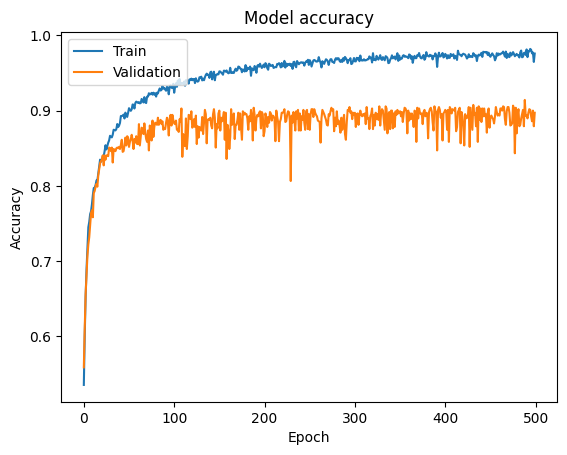

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['avg_accuracy'])
plt.plot(history.history['val_avg_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
model = load_model('./weight_cp/weight_lstm2.hdf5')
predictionss = model.predict(X_test)


In [13]:
predictions = np.where(predictionss[-1] > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Multi-Supervised LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Multi-Supervised LSTM
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       661
           1       0.91      0.90      0.90       662

    accuracy                           0.91      1323
   macro avg       0.91      0.91      0.91      1323
weighted avg       0.91      0.91      0.91      1323

0.9055177626606198


In [14]:
for i, layer in enumerate(model.layers):
    print(layer.name, i)

input_2 0
embedding_1 1
lstm_1 2
time_distributed 3
global_average_pooling1d 4
flatten 5
multiply 6
before_split 7
tf_op_layer_split 8
concatenate 9
reshape 10
conv2d 11
batch_normalization 12
flatten_1 13
op_main 14
op_conv 15
avg 16


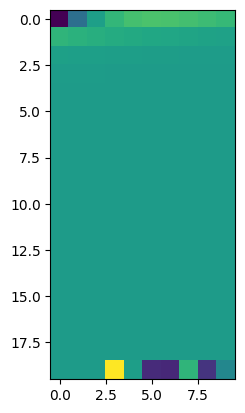

In [15]:
prr = 71
f = Model(model.input, model.layers[7].output)
predictions = f.predict(X_test)
plt.imshow(predictions[prr].reshape((20, 10)), cmap='viridis', interpolation='nearest')
plt.show()

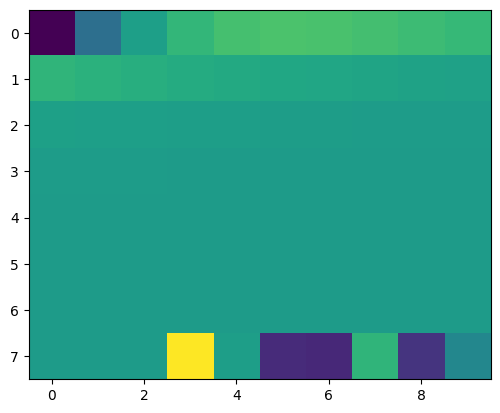

In [16]:
f = Model(model.input, model.layers[10].output)
predictions = f.predict(X_test)
plt.imshow(predictions[prr], cmap='viridis', interpolation='nearest')
plt.show()